In [2]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [6]:
from stepy.methods import fit_signal

## Simulate a trace with a linear step
To test out the step finding methods, I am simulating a trace with gaussian noise and a single linear step.

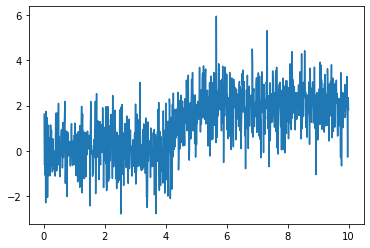

In [4]:
def linear_step_func(x, x0, x1,dy):
    y = np.piecewise(x, [
        x < x0,
        (x >= x0) & (x <= x1),
        x > x1],
        [0.,
            lambda x: x/(x1-x0)+x0/(x0-x1),
         1.]
    )
    return dy*y
dt = 0.01
step_size = 2
np.random.seed(1)
noise = np.random.normal(size=1000)
time = np.arange(dt,noise.size*dt+dt,dt)
trace = linear_step_func(time,4,5,2) + noise
plt.plot(time,trace)

{'step_height': [1.9679416339647218],
 'step_width': [0.9484588514652258],
 'dwell_time': [0],
 'step_rate': [2.0748835133169448],
 'step_start': [3.970004337157805]}

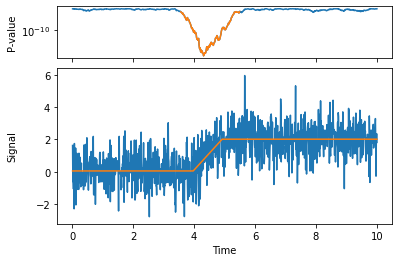

In [5]:
from stepy.methods import fit_signal
fs = fit_signal(trace, dt=dt)
fs.fit()
fs.plot()
fs.results

You can access the result using fs.output.params for the lmfit output or fs.results for a dictionary of results.

In [64]:
fs.output.params

name,value,standard error,relative error,initial value,min,max,vary
c,0.04550504,0.04937433,(108.50%),-0.09714089080609985,-inf,inf,True
s0_amplitude,1.96794163,0.06583647,(3.35%),6.542949651228245,-inf,inf,True
s0_center,3.97000434,0.09930179,(2.50%),4.525,-inf,inf,True
s0_sigma,0.94845885,0.17100669,(18.03%),0.9650000000000001,0.00000000,1.93000000,True


In [65]:
fs.results

{'step_height': [1.9679416339647218],
 'step_width': [0.9484588514652258],
 'dwell_time': [0],
 'step_rate': [2.0748835133169448],
 'step_start': [3.970004337157805]}

### Adding limits to fits

We can set a minimum or maximum step size using the parameters min_step_size and max_step_size. This may be helpful if there is additional noise in your data.

{'step_height': [1.9678594096421307],
 'step_width': [0.9460520497290402],
 'dwell_time': [0],
 'step_rate': [2.080075203267883],
 'step_start': [3.9700018569757267]}

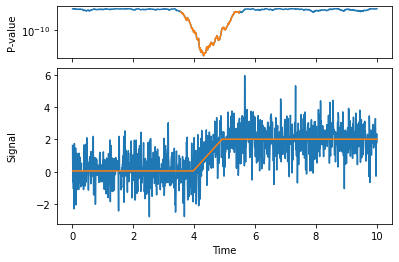

In [10]:
fs = fit_signal(trace, dt=dt)
fs.fit(min_step_size = 1)
fs.plot()
fs.results

A note of caution: if you set the step size too high, you may affect the rest of your fit, so it can account for the minimum step size.

{'step_height': [3.000000000003964],
 'step_width': [1.901331452855917],
 'dwell_time': [0],
 'step_rate': [1.5778416727382167],
 'step_start': [3.3900052667685037]}

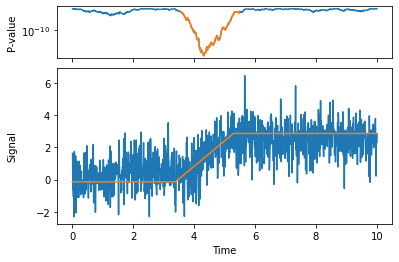

In [20]:
fs = fit_signal(trace, dt=dt)
fs.fit(min_step_size = 3)
fs.plot()
fs.results

Now, what happens if there is a small step either due to the enzyme or instrument.

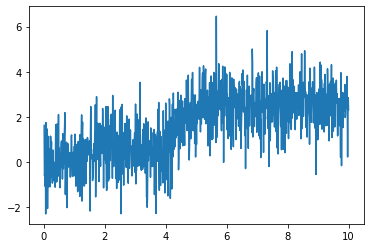

In [21]:
dt = 0.01
step_size = 2
np.random.seed(1)
noise = np.random.normal(size=1000)
time = np.arange(dt,noise.size*dt+dt,dt)
trace = linear_step_func(time,4,5,2) + linear_step_func(time,1,2,0.5) + noise
plt.plot(time,trace)

{'step_height': [2.154045220324544],
 'step_width': [0.9836455334069922],
 'dwell_time': [0],
 'step_rate': [2.1898591994452623],
 'step_start': [3.906359991761244]}

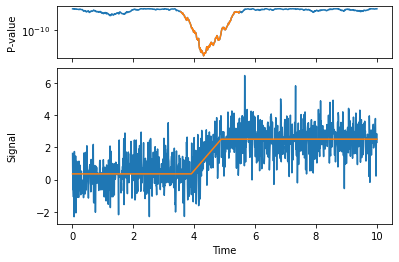

In [22]:
fs = fit_signal(trace, dt=dt)
fs.fit(min_step_size = 0)
fs.plot()
fs.results

Stepy misses the small step becauses it's small in comparison the noise. To capture the step, we need to increase the maximum p-value threshold to 0.5. This will only work if the steps are well-separated and have a dip that meets the minimum p-value threshold (by default, 0.005).  

{'step_height': [0.46776299006980504, 1.9905922739639794],
 'step_width': [0.581837497492608, 0.9419866011503851],
 'dwell_time': [0, 2.2799407941742524],
 'step_rate': [0.8039409492952931, 2.1131853378094787],
 'step_start': [1.1082039399205919, 3.9699822315874522]}

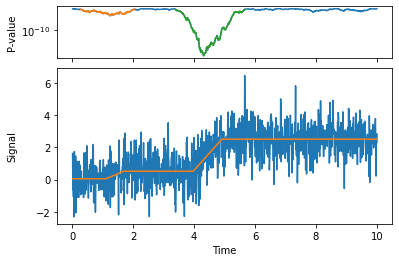

In [33]:
from stepy.methods import fit_signal
fs = fit_signal(trace, dt=dt, max_threshold=0.5)
fs.fit(min_step_size = 0)
fs.plot()
fs.results

If you capture a step but want to exclude it based on step size, you can exclude it and redo the fit.

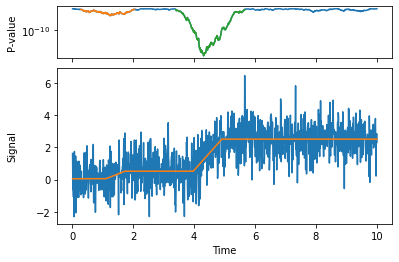

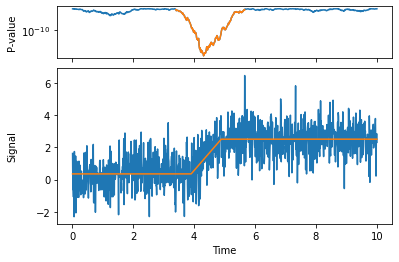

In [44]:
fs = fit_signal(trace, dt=dt, max_threshold=0.5)
fs.fit()
fs.plot()
step_sizes = np.array(fs.results['step_height'])
msk = step_sizes < 1
if any(msk):
    fs.regions = fs.regions[~msk]
    fs.fit()
    fs.plot()

## Simulate example trace with instantaneous jump
To test out the step finding methods, I am simulating a trace with gaussian noise and a single instantaneous step.

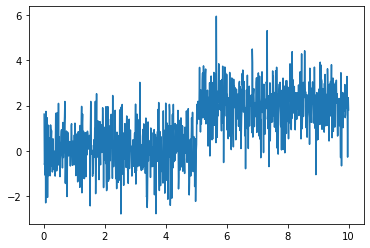

In [7]:
dt = 0.01
step_size = 2
np.random.seed(1)
trace = np.random.normal(size=1000)
trace[500:] += step_size
time = np.arange(dt,trace.size*dt+dt,dt)
plt.plot(time,trace)


{'step_height': [1.9763548812708924],
 'step_width': [0.045203847015275106],
 'dwell_time': [0],
 'step_rate': [43.72094438340724],
 'step_start': [4.997306214418274]}

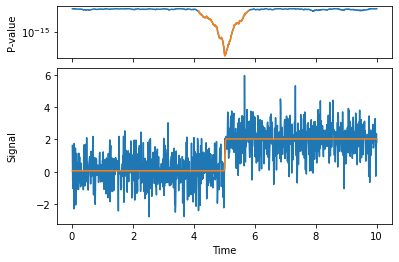

In [9]:
fs = fit_signal(trace, dt=dt)
fs.fit()
fs.plot()
fs.results

You'll notice that the step still has a width even though it is an instantaneous jump. You can force the steps to be instantaneous by fixing the step width to 0.

c:\users\morganil\documents\code\stepy\src\stepy\methods.py:144: RuntimeWarning: divide by zero encountered in double_scalars


{'step_height': [1.94490535698126],
 'step_width': [0],
 'dwell_time': [0],
 'step_rate': [inf],
 'step_start': [4.97]}

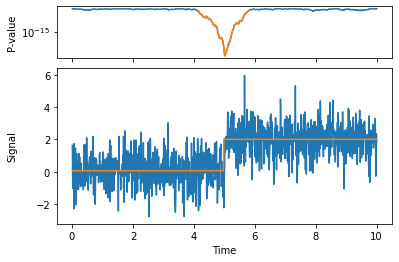

In [17]:
fs = fit_signal(trace, dt=dt)
fs.fit(fixed_step_width = 0)
fs.plot()
fs.results